In [1]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import pickle
import math
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import Image as ipimag
from PIL import Image as pimag
import glob
outdir= "modelsol"
pi = 3.14159
% matplotlib inline

In [2]:
#Functions for the main pipeline are defined here 
def undistort_image(image,mtx,dist):
    undist_image = cv2.undistort(image,mtx,dist,None,mtx)
    return undist_image
def gaussian_blur(image,kernel=5):
    blur_image = cv2.GaussianBlur(image,(kernel,kernel),0)
    return blur_image
def clahe(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(6,6))    
    transform = clahe.apply(v)
    res= cv2.merge((h,s,transform))
    res = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
    return res
def abs_sobel(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output
def mag_thresh(img, sobel_kernel=3, thresh=(20,100)):
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))    
    binary_output = 0*grad_s 
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut
def warp_image(img,src,dst,img_size):
    Mat = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, Mat, img_size, flags=cv2.INTER_LINEAR)
    Mat_inv = cv2.getPerspectiveTransform(dst, src)
    return warped,Mat,Mat_inv
def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask
def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=int)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

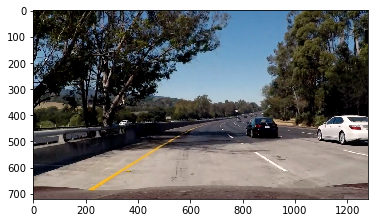

In [3]:
cal = pickle.load(open("camera_calibration.pkl" , "rb"))
mtx_camera = cal[0]
dist_camera = cal[1]
image = mpimg.imread(open('test_images/test5.jpg','rb'))
plt.imshow(image)
plt.show()
#plt.axis('off');

In [12]:
def get_first(image, window):
    image = gaussian_blur(image,5)
    shape = np.shape(image)
    filter_size = int(shape[1]/50)
    me = np.mean(image[int(shape[0]/2):,:],axis=0)#mean along y-axis
    hist = moving_average(me, filter_size)
    peaks = find_peaks_cwt(hist,[100],max_distances = [800])
    valid_peaks = np.array(hist[peaks[i]] for i in range(len(peaks)))
    peaks_sorted = np.argsort(-valid_peaks)
    
    R_peak = peaks[peaks_sorted[1]]
    L_peak = peaks[peaks_sorted[0]]    
    if R_peak < L_peak:
        temp = R_peak
        R_peak = L_peak
        L_peak = temp
    n_vals = 8
    min_L = L_peak-window
    max_L = L_peak+window
    min_R = R_peak-window
    max_R = R-peak+window
    
    Left_mask = np.zeros_like(image)
    Right_mask= np.zeros_like(image)
    
    pre_R_peak = R_peak
    pre_L_peak = L_peak
    
    d_R = 0
    d_L = 0
    for i in range(8):
        image_y1 = int(shape[0]-shape[0]*i/8)
        image_y2 = int(shape[0]-shape[0]*(i+1)/8)
        
        mean_lane_y = np.mean(image[int(image_y2:image_y1,:)],axis=0)
        mean_lane_y = moving_average(mean_lane_y,filter_size)
        y_peaks = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(y_peaks)>1.5:
            valid_y_peaks = np.array([mean_lane_y[y_peaks[i]] for i in range(len(y_peaks))])
            sorted_peaks_y = np.argsort(-valid_y_peaks)
            
            y_peaks_R = y_peaks[sorted_peaks_y[1]]
            y_peaks_L = y_peaks[sorted_peaks_y[0]]
            
            if y_peaks_R <y_peaks_L:
                temp = y_peaks_R
                y_peaks_R = y_peaks_L
                y_peaks_l = temp
                
        else:
            if len(y_peaks) == 1:
                if np.abs(y_peaks[0]-pre_R_peak) < np.abs(y_peaks[0]-pre_L_peak):
                    y_peaks_R = y_peaks[0]
                    y_peaks_L = pre_L_peak + d_L
                else:
                    y_peaks_L = y_peaks[0]
                    y_peaks_R = pre_R_peak +d_R
            else:
                y_peaks_L = pre_L_peak + diff_L
                y_peaks_R = pre_R_peak + diff_R
        
        if np.abs(y_peaks_L - pre_L_peak) >=100:
            y_peaks_L = pre_L_peak
        if np.abs(y_peaks_R - pre_R_peak) >=100:
            y_peaks_R = pre_R_peak
            
        Left_mask[int(image_y2):int(image_y1), int(y_peaks_L -window):int(y_peaks_L+window))] = 1
        Right_mask[int(image_y2):int(image_y1), int(y_peaks_L -window):int(y_peaks_L+window))] = 1
        
        if i == 0:
            window = window/1
        if i>0 :
            d_R = y_peaks_L - pre_L_peak
            d_L = y_peaks_R - pre_R_peak
        
        pre_L_peak = y_peaks_L
        pre_R_peak = y_peaks_R
        
    
    return Left_mask, Right_mask            
    

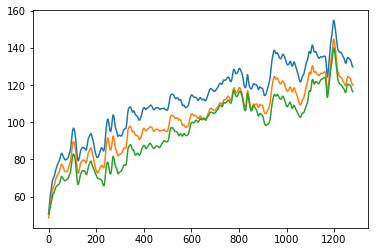

mememe  :  [[  51.18611111   48.575        50.525     ]
 [  51.66111111   48.93333333   50.79444444]
 [  52.82777778   49.73611111   51.36666667]
 ..., 
 [ 129.97222222  120.175       116.63333333]
 [ 129.79444444  120.03611111  116.45      ]
 [ 129.74444444  119.99722222  116.38333333]]


In [11]:
image = gaussian_blur(image,5)
shape = np.shape(image)
filter_size = int(shape[1]/50)
me = np.mean(image[int(shape[0]/2):,:],axis=0)
plt.plot(me)
plt.show()
print('mememe  : ',me)